[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MSIA/msia432-meme-generation-project/blob/main/notebooks/03_basic_model_modify.ipynb)

## Setup

In [1]:
# !rm -r data
# !rm -r msia432-meme-generation-project
# !rm -r checkpoints

In [2]:
#!pip install fastprogress

In [3]:
import collections
import random
import os
from pathlib import Path
import time
import json
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
from fastprogress.fastprogress import progress_bar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
data_path = Path('../data')

In [5]:
# Adapted from: https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    in_colab = True
except Exception:
    in_colab = False

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Training can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print('NUM GPUS:', len(tf.config.list_physical_devices('GPU')))

NUM GPUS: 1


## Model Configuration

In [6]:
random.seed(36)
np.random.seed(36)
tf.random.set_seed(36)

In [57]:
subset = True
subset_size = 20_000

epochs = 2

# Choose how many words from the vocabulary, default to 5000
top_k = 6000

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1

# Image ReSize Target 
img_size = (299, 299)

# Which model to use for encoder 
model_name = 'resnet50'

# Calculate bleu score for how many sentences in the validation set, default 200 (None means whole validation set)
bleu_num = 1000

# whether to save checkpoint
save = False

In [8]:
def assign_model(image_model):
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output
    return keras.Model(new_input, hidden_layer)

In [9]:
if model_name == 'resnet50':
    preprocess_func = keras.applications.resnet.preprocess_input
    
    image_model = keras.applications.ResNet50(include_top=False, weights='imagenet')
    image_features_extract_model = assign_model(image_model)

elif model_name == 'inception_v3':
    preprocess_func = keras.applications.inception_v3.preprocess_input
    image_model = keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
    image_features_extract_model = assign_model(image_model)

elif model_name == 'InceptionResNetV2':
    preprocess_func = keras.applications.inception_resnet_v2.preprocess_input
    image_model = keras.applications.InceptionResNetV2(include_top=False,
                                                       weights='imagenet')
    image_features_extract_model = assign_model(image_model)    

elif model_name == 'EfficientNetB1':
    preprocess_func = keras.applications.efficientnet.preprocess_input
    image_model = keras.applications.EfficientNetB1(include_top=False,
                                                    weights='imagenet')
    image_features_extract_model = assign_model(image_model)

## Load Data

In [10]:
if in_colab and not os.path.exists('data'):
  !git clone https://github.com/MSIA/msia432-meme-generation-project.git
  !mv msia432-meme-generation-project/data .
  df_match = pd.read_csv('data/data_match.csv')
elif not in_colab:
  df_match = pd.read_csv(data_path / 'data_match.csv')
elif in_colab and os.path.exists('data'):
  df_match = pd.read_csv('data/data_match.csv')
else:
  print('check your data path!')

In [11]:
df_match['image_path'] = df_match['image_path'].str.replace('\../', '')

In [12]:
df_match.head(2)

,label,text,impute_image_name,real_image_name,image_path
0,y-u-no,<start> meme generator users y u no give me mo...,y-u-no.jpg,y-u-no.jpg,data/memes/y-u-no.jpg
1,y-u-no,<start> steve jobs y u no respawn?! <end>,y-u-no.jpg,y-u-no.jpg,data/memes/y-u-no.jpg


In [13]:
train_captions = list(df_match['text'].values)
img_name_vector = list(df_match['image_path'].values)

In [14]:
len(train_captions), len(img_name_vector)

(409831, 409831)

In [15]:
train_captions[0:2]

['<start> meme generator users y u no give me more upvotes? <end>',
 '<start> steve jobs y u no respawn?! <end>']

In [16]:
img_name_vector[0:2]

['data/memes/y-u-no.jpg', 'data/memes/y-u-no.jpg']

#### Optional: use a subset

In [17]:
if subset:
  train_captions = train_captions[:subset_size]
  img_name_vector = img_name_vector[:subset_size]
  assert (len(train_captions), len(img_name_vector)) == (subset_size, subset_size)

### Show the image

<start> meme generator users y u no give me more upvotes? <end>


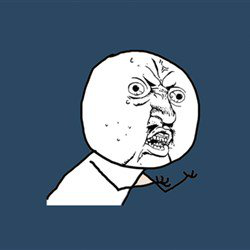

In [18]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess

### Preprocess the images using ResetNet50

In [19]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = preprocess_func(img)
    return img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


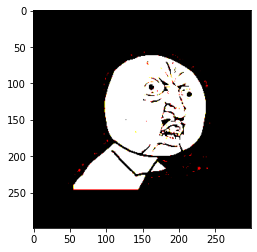

In [20]:
plt.imshow(load_image(img_name_vector[0])[0])

In [21]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in  progress_bar(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [22]:
# Shape of the vector extracted from the pretrained model
attention_features_shape, features_shape = tuple(batch_features.shape[1:3])

In [23]:
attention_features_shape, features_shape

(100, 2048)

### Preprocess and tokenize the captions

In [24]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [25]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=top_k,
                                               oov_token="<unk>",
                                               filters='"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [26]:
assert top_k <= len(list(tokenizer.word_index))

In [27]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [29]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [30]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

### Split the data into training and testing

In [31]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(15940, 15940, 4060, 4060)

### Create a tf.data dataset for training


In [33]:
num_steps = len(img_name_train) // BATCH_SIZE

In [34]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [36]:
class BahdanauAttention(keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = keras.layers.Dense(units)
    self.W2 = keras.layers.Dense(units)
    self.V = keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [37]:
class CNN_Encoder(keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [38]:
class RNN_Decoder(keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(self.units,
                                return_sequences=True,
                                return_state=True,
                                recurrent_initializer='glorot_uniform')
    self.fc1 = keras.layers.Dense(self.units)
    self.fc2 = keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [39]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [40]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [41]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [42]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [43]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [44]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [45]:
EPOCHS = epochs

for epoch in progress_bar(range(start_epoch, EPOCHS)):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if save and epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')

Epoch 1 Batch 0 Loss 1.7720
Epoch 1 Batch 100 Loss 1.1554
Epoch 1 Batch 200 Loss 1.1890
Epoch 1 Loss 1.219296
Epoch 2 Batch 0 Loss 1.2349
Epoch 2 Batch 100 Loss 0.9979
Epoch 2 Batch 200 Loss 0.9586
Epoch 2 Loss 1.050605


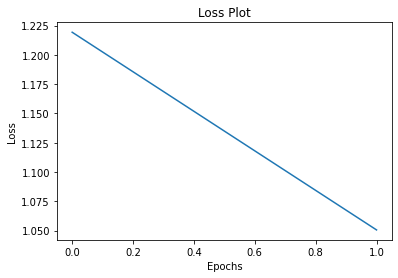

In [46]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [48]:
image_features_extract_model.save_weights('img_feature_model.h5')
encoder.save_weights('encoder.h5')
decoder.save_weights('decoder.h5')

## Evaluate 

In [49]:
def predict_sentence(img_val, idx):

    image = img_val[idx]
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [50]:
def get_real_caption(cap_val, idx):
    return [tokenizer.index_word[i] for i in cap_val[idx] if i not in [0]]

In [51]:
def get_bleu(reference, candidate):
    return sentence_bleu(reference, candidate)

In [52]:
def evaluate_one_pair(img_val, cap_val, idx, show_pair=True):

    pred_sentence = predict_sentence(img_val, idx)
    real_sentence = get_real_caption(cap_val, idx)

    if '<end>' in pred_sentence:
        pred_sentence.remove('<end>')
    real_sentence.remove('<start>')
    real_sentence.remove('<end>')

    if show_pair:
        print('Predicted caption:', ' '.join(pred_sentence))
        print('Real caption:', ' '.join(real_sentence))

    return get_bleu(real_sentence, pred_sentence)

In [53]:
len(img_name_val), len(cap_val)

(4060, 4060)

In [54]:
def get_bleu_array(img_val, cap_val, cal_length=None):
    error_count = 0
    bleu_list = []
    if cal_length is None:
        val_len = range(len(img_name_val))
    else:
        val_len = range(cal_length)
    for i in progress_bar(val_len):
        try:
            bleu_score = evaluate_one_pair(img_name_val, cap_val, i, show_pair=False)
            bleu_list.append(bleu_score)
        except KeyError:
            print(i)
            error_count += 1
    return np.array(bleu_list), error_count

In [59]:
bleu_arr, error_count = get_bleu_array(img_name_val, cap_val, bleu_num)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


180
319
325
350
371


In [60]:
np.mean(bleu_arr)

0.2320630673696805

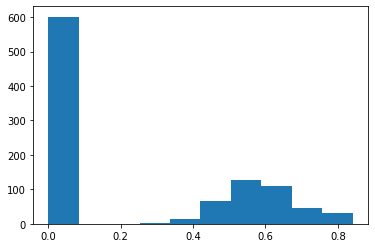

In [61]:
plt.hist(bleu_arr)
plt.show()

## Caption!

### Useful Functions

In [62]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [63]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### Make Captions

In [64]:
rand_l = np.random.choice([*range(2000)], size=20, replace=False)
rand_l

array([1478, 1137,  155,  445,  740, 1903, 1821,  258,  931,  496, 1151,
       1015,  211,  708, 1734,  128, 1711, 1031, 1379, 1075])

In [65]:
for i in rand_l:
    pred = ' '.join(predict_sentence(img_name_val, i))
    print(i, pred)

1478 i got sure if she dress <unk> out of air <end>
1137 look! must have <unk> <end>
155 what would some food symptoms as river i saw your week what you didnt charity <end>
445 t dont liked toilet <end>
740 cleaned the office is to it <unk> is homework i would start brings a butt is 30 viruses <unk> the knee is are we jokes to shower <unk> reply classroom miss my pizza for your parents don't lemons player friends don't can silly money giving me until me to 90's cat <unk> so millennial
1903 microsoft to bed for car <end>
1821 seen the only we wonder i always life to go are ever is a loss we drop marijuana <end>
258 con !! <end>
931 maybe got my favorite year of my wife ball <end>
496 then its disney says my own sense white having pulling photon mouse while you play new spray by cockroaches starting to school and oh you invites on us to make her out <end>
1151 <unk> in the hell are have hammer <end>
1015 wtf <unk> on russia bad paper and <unk> <end>
211 work out of americans <end>
708 li

In [66]:
' '.join(get_real_caption(cap_val, 1865))

'<start> yes i am tarantino <end>'

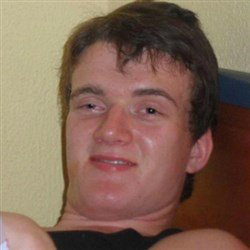

In [67]:
Image.open(img_name_val[1865])

Real Caption: <start> you've got a pretty mouth let me break it <end>
Prediction Caption: started people <unk> <end>


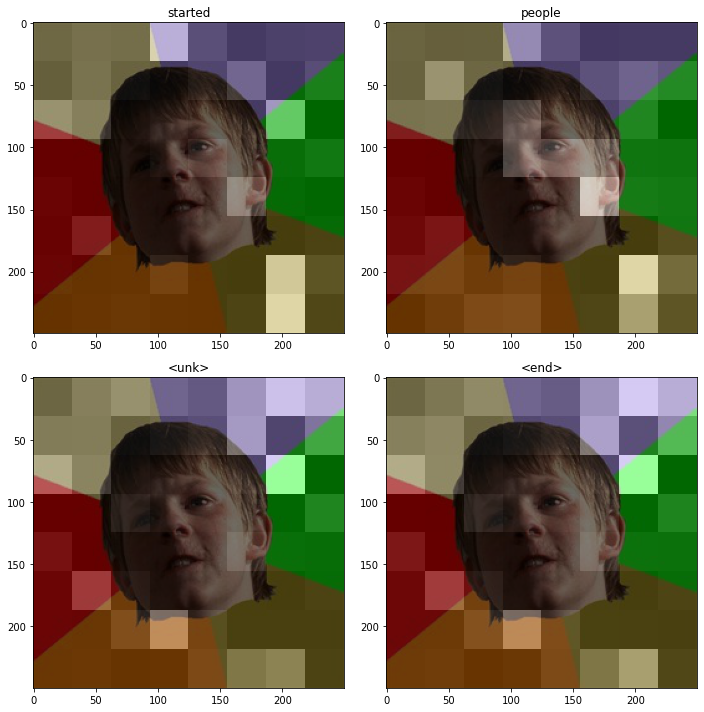

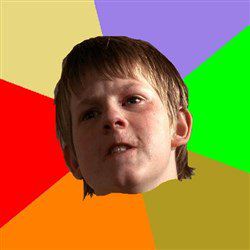

In [68]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [69]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = keras.utils.get_file('image'+image_extension, origin=image_url)

65536/64400 [==============================] - 0s 1us/step


In [70]:
# image_path = 'adam.png'

Prediction Caption: my birthday changes it's enough into out of bear is celebrating days <end>


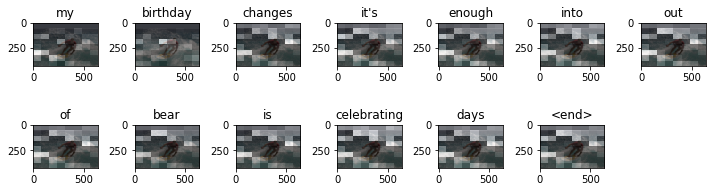

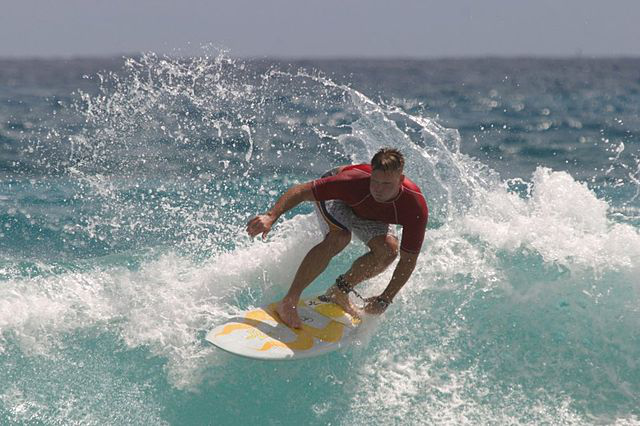

In [71]:
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)